# Football Tracker - Data Visualization and Analysis

This notebook implements the computer vision system for automatic ball detection and speed estimation in football matches as described in the proposal.

## Dataset Overview
- **Classes**: ball (0), goalkeeper (1), player (2), referee (3)
- **Format**: YOLO format (class x_center y_center width height)
- **Focus**: Ball and players (ignoring goalkeepers and referees)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from pathlib import Path
import yaml

# Set up paths
DATA_DIR = Path('../data')
TRAIN_IMAGES = DATA_DIR / 'train' / 'images'
TRAIN_LABELS = DATA_DIR / 'train' / 'labels'

# Load class names
with open(DATA_DIR / 'data.yaml', 'r') as f:
    data_config = yaml.safe_load(f)
    
class_names = data_config['names']
print(f"Classes: {class_names}")
print(f"Number of classes: {len(class_names)}")

Classes: ['ball', 'goalkeeper', 'player', 'referee']
Number of classes: 4


### Data Exploration

In [2]:
# Count images and labels
image_files = list(TRAIN_IMAGES.glob('*.jpg'))
label_files = list(TRAIN_LABELS.glob('*.txt'))

print(f"Training images: {len(image_files)}")
print(f"Training labels: {len(label_files)}")

# Sample image names
print(f"\nSample images:")
for i in range(3):
    print(f"  {image_files[i].name}")

Training images: 612
Training labels: 612

Sample images:
  744b27_3_2_png.rf.732528c6c763dc262be638cee76a358a.jpg
  538438_7_7_png.rf.f80ce9c7b9ebc271a4301c4e6f5c99ef.jpg
  798b45_1_6_png.rf.c24783c9442d3c63d0eb7c532d22e486.jpg


In [3]:
def load_annotations(label_path):
    """Load YOLO format annotations"""
    annotations = []
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])
                    annotations.append([class_id, x_center, y_center, width, height])
    return annotations

def yolo_to_bbox(x_center, y_center, width, height, img_width, img_height):
    """Convert YOLO format to bounding box coordinates"""
    x1 = int((x_center - width/2) * img_width)
    y1 = int((y_center - height/2) * img_height)
    x2 = int((x_center + width/2) * img_width)
    y2 = int((y_center + height/2) * img_height)
    return x1, y1, x2, y2

def visualize_annotations(image_path, annotations, title=""):
    """Visualize image with annotations"""
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    # Color map for different classes
    colors = {
        0: (255, 0, 0),    # ball - red
        1: (0, 255, 0),    # goalkeeper - green
        2: (0, 0, 255),    # player - blue
        3: (255, 255, 0)   # referee - yellow
    }
    
    for ann in annotations:
        class_id, x_center, y_center, width, height = ann
        x1, y1, x2, y2 = yolo_to_bbox(x_center, y_center, width, height, w, h)
        
        color = colors.get(class_id, (128, 128, 128))
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        
        # Add class label
        label = class_names[class_id]
        cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()
    
    return img

### Sample Data Visualization


Image: 798b45_7_3_png.rf.3bc218b7996402acb54e4198d96b3b68.jpg
Annotations: 22
  player: 20
  referee: 2


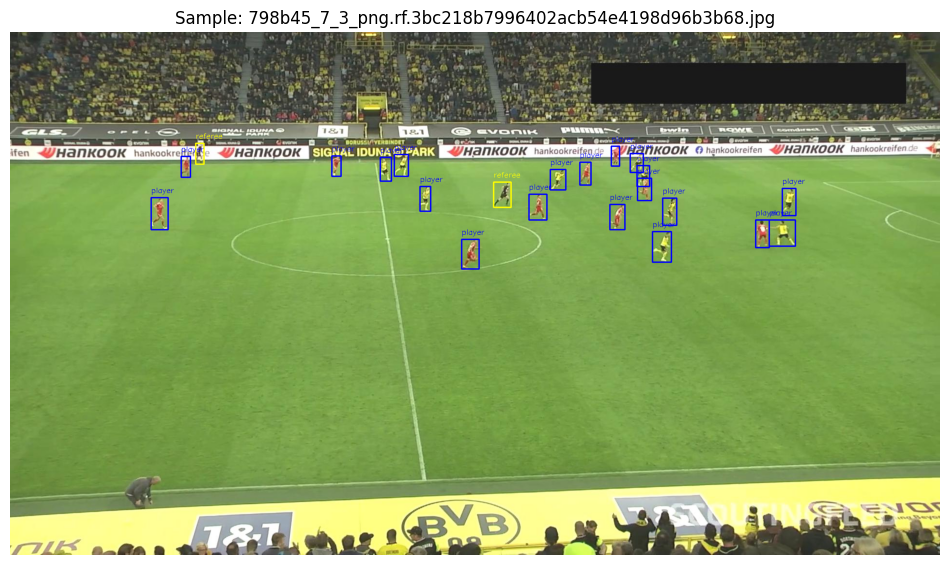


Image: 538438_7_4_png.rf.31343e3fbf978bac313c3a56356fce33.jpg
Annotations: 24
  player: 20
  referee: 2
  goalkeeper: 1
  ball: 1


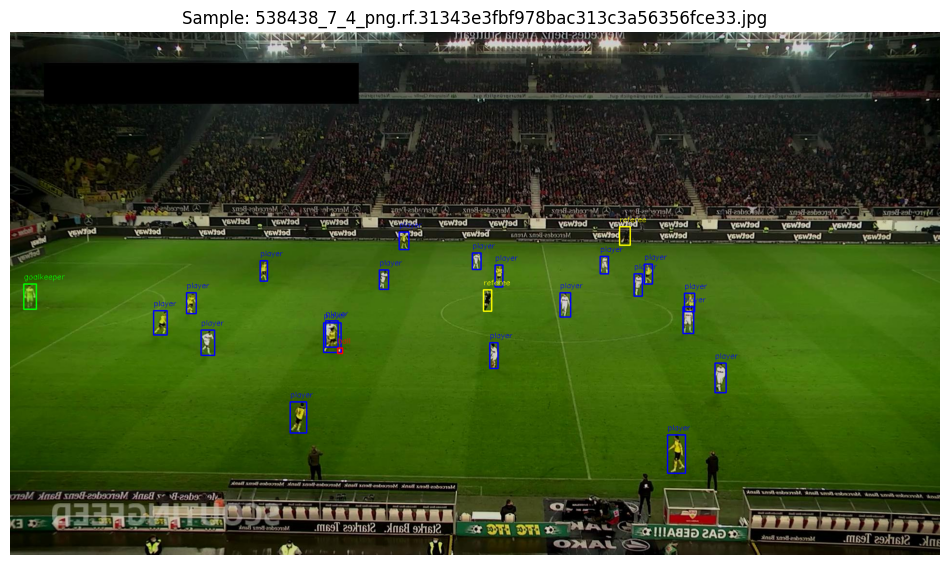


Image: 42ba34_1_1_png.rf.b172c0ffce58453df63b1ade710843af.jpg
Annotations: 22
  referee: 2
  player: 20


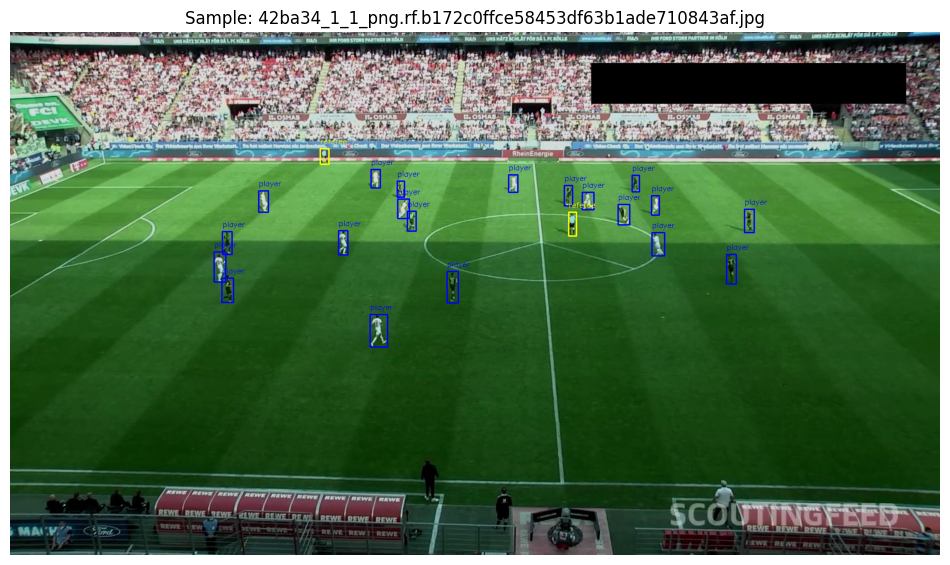

In [4]:
# Visualize random samples
sample_images = random.sample(image_files, 3)

for img_path in sample_images:
    # Get corresponding label file
    label_path = TRAIN_LABELS / (img_path.stem + '.txt')
    annotations = load_annotations(label_path)
    
    print(f"\nImage: {img_path.name}")
    print(f"Annotations: {len(annotations)}")
    
    # Count objects by class
    class_counts = {}
    for ann in annotations:
        class_id = ann[0]
        class_counts[class_id] = class_counts.get(class_id, 0) + 1
    
    for class_id, count in class_counts.items():
        print(f"  {class_names[class_id]}: {count}")
    
    visualize_annotations(img_path, annotations, f"Sample: {img_path.name}")

### Dataset Statistics

In [5]:
# Analyze dataset statistics
total_objects = {i: 0 for i in range(len(class_names))}
images_with_ball = 0
images_with_players = 0
ball_sizes = []
player_sizes = []

for img_path in image_files:
    label_path = TRAIN_LABELS / (img_path.stem + '.txt')
    annotations = load_annotations(label_path)
    
    has_ball = False
    has_players = False
    
    for ann in annotations:
        class_id, x_center, y_center, width, height = ann
        total_objects[class_id] += 1
        
        if class_id == 0:  # ball
            has_ball = True
            ball_sizes.append(width * height)  # relative size
        elif class_id == 2:  # player
            has_players = True
            player_sizes.append(width * height)
    
    if has_ball:
        images_with_ball += 1
    if has_players:
        images_with_players += 1

print("Dataset Statistics:")
print(f"Total images: {len(image_files)}")
print(f"Images with ball: {images_with_ball} ({images_with_ball/len(image_files)*100:.1f}%)")
print(f"Images with players: {images_with_players} ({images_with_players/len(image_files)*100:.1f}%)")
print("\nObject counts:")
for class_id, count in total_objects.items():
    print(f"  {class_names[class_id]}: {count}")

print(f"\nBall size statistics (relative):")
if ball_sizes:
    print(f"  Mean: {np.mean(ball_sizes):.6f}")
    print(f"  Std: {np.std(ball_sizes):.6f}")
    print(f"  Min: {np.min(ball_sizes):.6f}")
    print(f"  Max: {np.max(ball_sizes):.6f}")

Dataset Statistics:
Total images: 612
Images with ball: 516 (84.3%)
Images with players: 612 (100.0%)

Object counts:
  ball: 519
  goalkeeper: 435
  player: 12228
  referee: 1401

Ball size statistics (relative):
  Mean: 0.000067
  Std: 0.000026
  Min: 0.000019
  Max: 0.000162


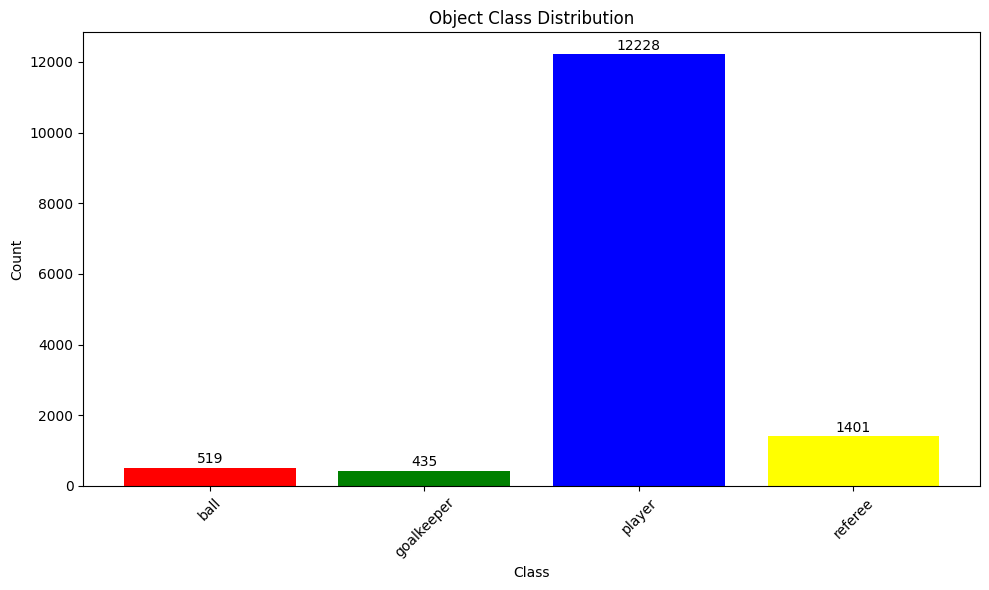

In [6]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
classes = [class_names[i] for i in range(len(class_names))]
counts = [total_objects[i] for i in range(len(class_names))]

plt.bar(classes, counts, color=['red', 'green', 'blue', 'yellow'])
plt.title('Object Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
for i, count in enumerate(counts):
    plt.text(i, count + max(counts)*0.01, str(count), ha='center')
plt.tight_layout()
plt.show()

## Ball Detection Focus

Since our proposal focuses on ball detection and tracking, let's analyze images specifically containing balls.

Images containing balls: 516


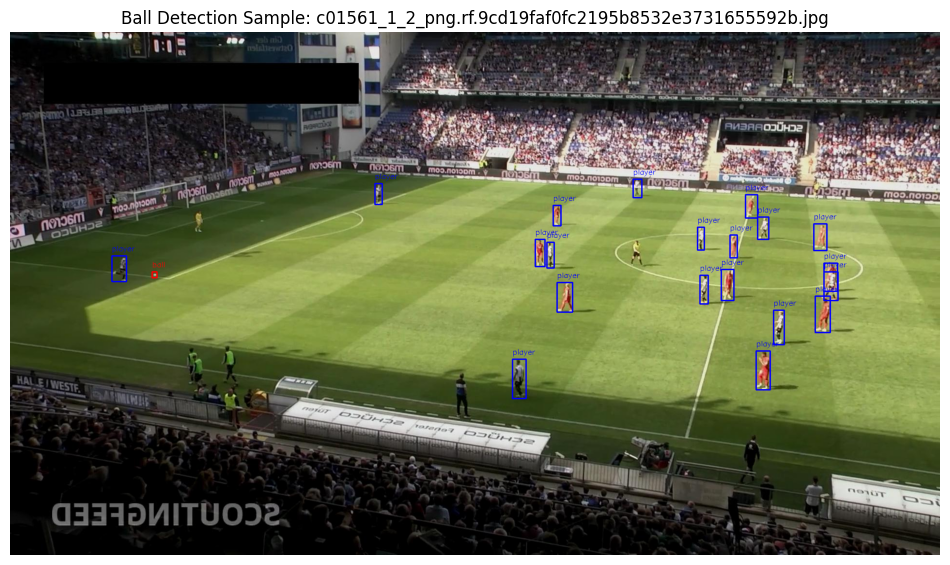

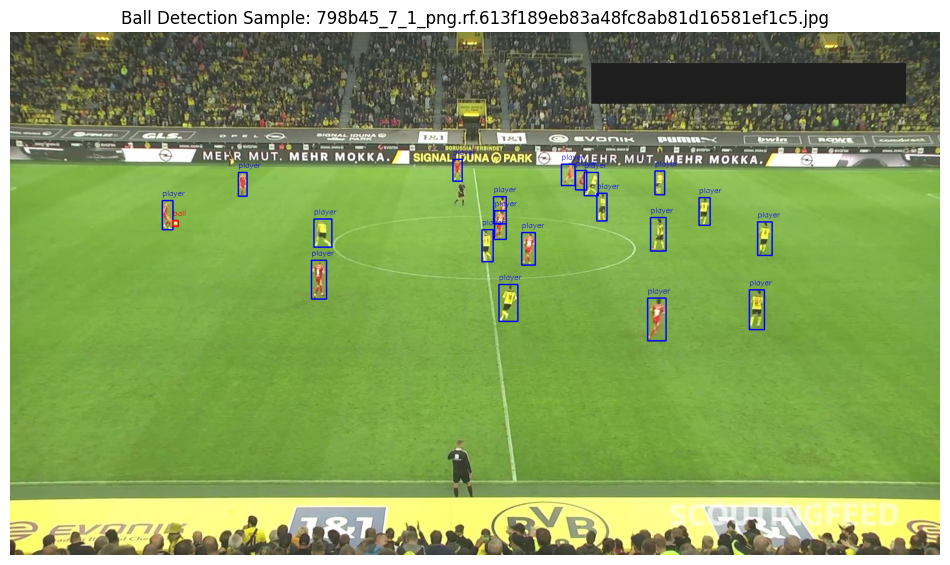

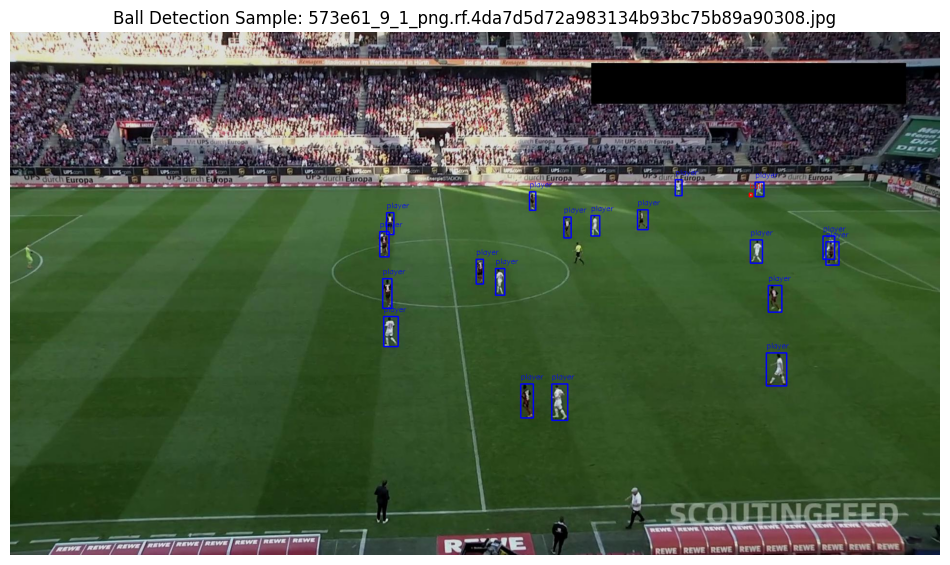

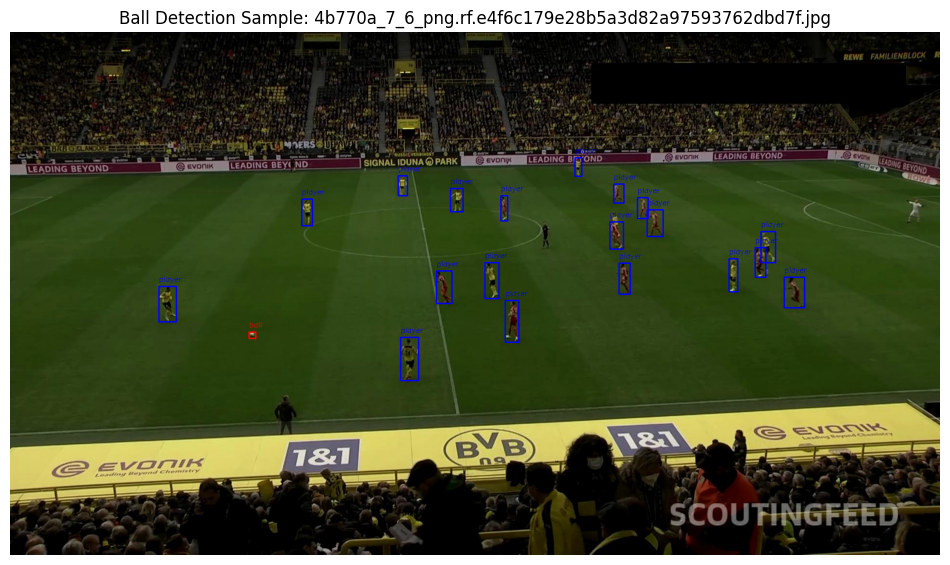

In [7]:
# Find images with balls
ball_images = []
for img_path in image_files:
    label_path = TRAIN_LABELS / (img_path.stem + '.txt')
    annotations = load_annotations(label_path)
    
    for ann in annotations:
        if ann[0] == 0:  # ball class
            ball_images.append(img_path)
            break

print(f"Images containing balls: {len(ball_images)}")

# Visualize some ball examples
ball_samples = random.sample(ball_images, min(4, len(ball_images)))

for img_path in ball_samples:
    label_path = TRAIN_LABELS / (img_path.stem + '.txt')
    annotations = load_annotations(label_path)
    
    # Filter to show only balls and players (as per proposal)
    filtered_annotations = [ann for ann in annotations if ann[0] in [0, 2]]  # ball and players only
    
    visualize_annotations(img_path, filtered_annotations, f"Ball Detection Sample: {img_path.name}")

### Ball Size Analysis

Understanding ball sizes is crucial for detection algorithms.

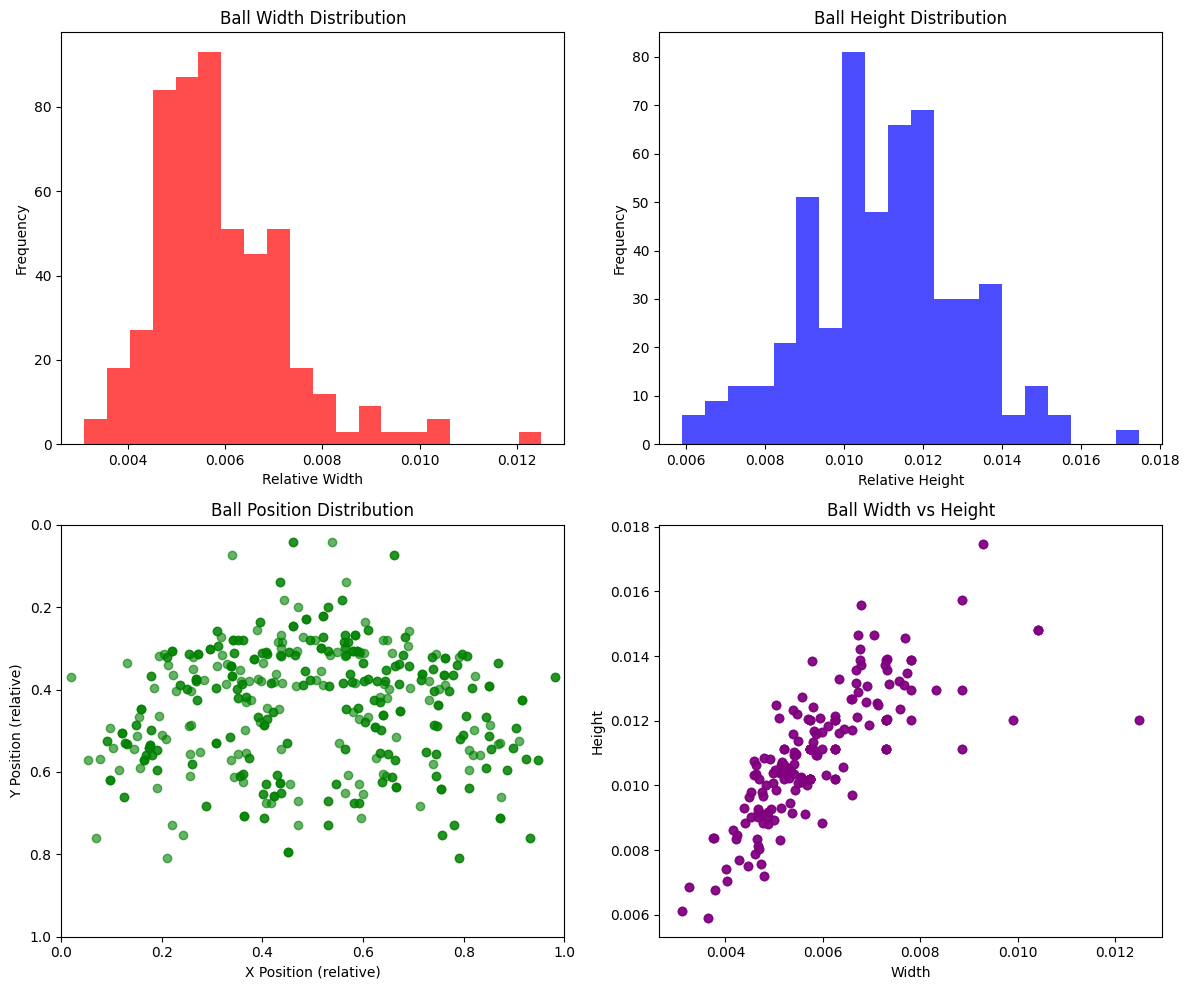

Ball statistics:
  Width - Mean: 0.0059, Std: 0.0014
  Height - Mean: 0.0110, Std: 0.0020
  Aspect ratio - Mean: 0.5375


In [8]:
# Analyze ball sizes in detail
ball_widths = []
ball_heights = []
ball_positions_x = []
ball_positions_y = []

for img_path in ball_images:
    label_path = TRAIN_LABELS / (img_path.stem + '.txt')
    annotations = load_annotations(label_path)
    
    for ann in annotations:
        if ann[0] == 0:  # ball
            class_id, x_center, y_center, width, height = ann
            ball_widths.append(width)
            ball_heights.append(height)
            ball_positions_x.append(x_center)
            ball_positions_y.append(y_center)

# Plot ball size distribution
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].hist(ball_widths, bins=20, alpha=0.7, color='red')
axes[0, 0].set_title('Ball Width Distribution')
axes[0, 0].set_xlabel('Relative Width')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(ball_heights, bins=20, alpha=0.7, color='blue')
axes[0, 1].set_title('Ball Height Distribution')
axes[0, 1].set_xlabel('Relative Height')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].scatter(ball_positions_x, ball_positions_y, alpha=0.6, color='green')
axes[1, 0].set_title('Ball Position Distribution')
axes[1, 0].set_xlabel('X Position (relative)')
axes[1, 0].set_ylabel('Y Position (relative)')
axes[1, 0].set_xlim(0, 1)
axes[1, 0].set_ylim(0, 1)
axes[1, 0].invert_yaxis()  # Invert Y axis to match image coordinates

axes[1, 1].scatter(ball_widths, ball_heights, alpha=0.6, color='purple')
axes[1, 1].set_title('Ball Width vs Height')
axes[1, 1].set_xlabel('Width')
axes[1, 1].set_ylabel('Height')

plt.tight_layout()
plt.show()

print(f"Ball statistics:")
print(f"  Width - Mean: {np.mean(ball_widths):.4f}, Std: {np.std(ball_widths):.4f}")
print(f"  Height - Mean: {np.mean(ball_heights):.4f}, Std: {np.std(ball_heights):.4f}")
print(f"  Aspect ratio - Mean: {np.mean(np.array(ball_widths)/np.array(ball_heights)):.4f}")

## Preprocessing Pipeline

Implementing the preprocessing steps mentioned in the proposal.

Preprocessing sample: 744b27_7_10_png.rf.b5cc498670b03018318966869a23d750.jpg


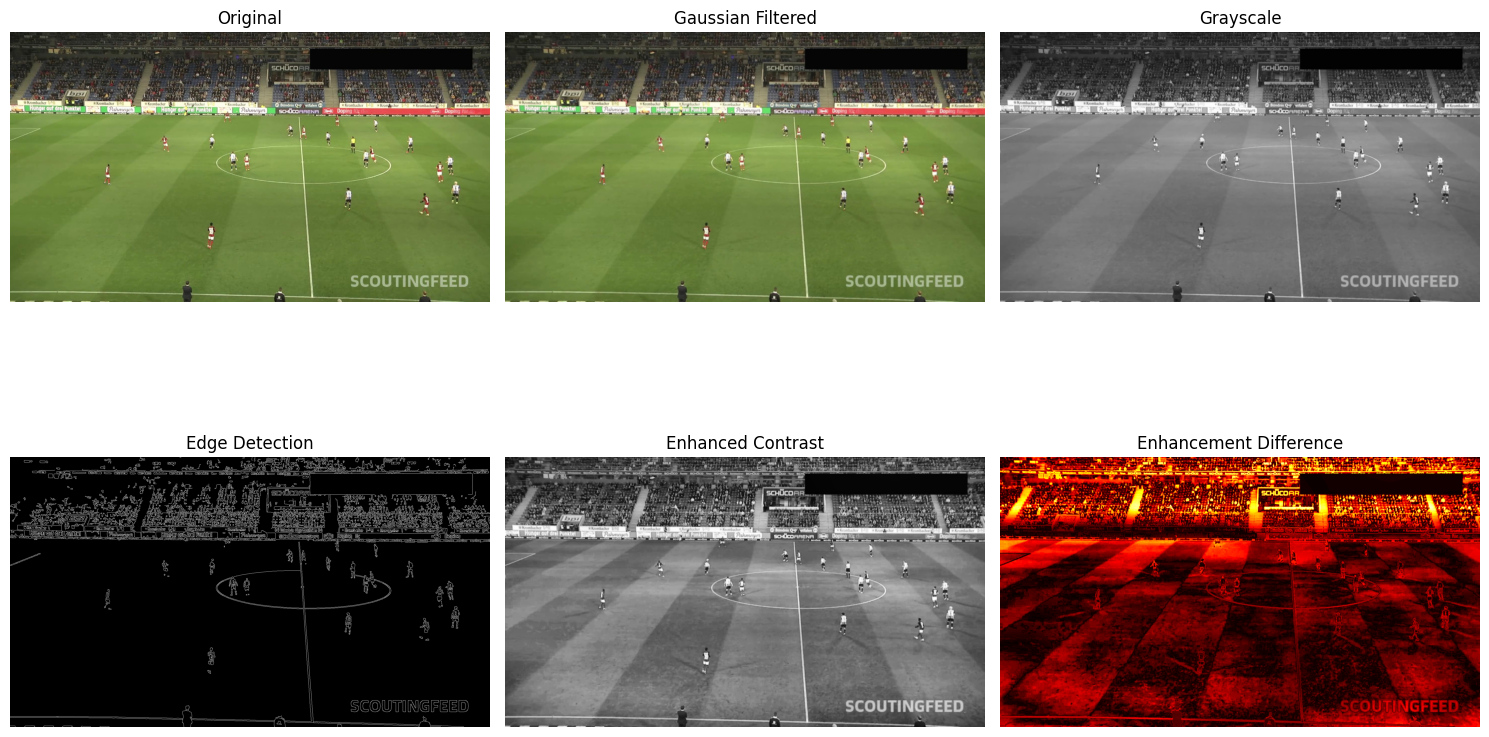

In [9]:
def preprocess_image(image_path, show_steps=True):
    """Apply preprocessing steps as described in the proposal"""
    # Load image
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 1. Gaussian filter for noise reduction
    gaussian_filtered = cv2.GaussianBlur(img_rgb, (5, 5), 0)
    
    # 2. Convert to grayscale for edge detection
    gray = cv2.cvtColor(gaussian_filtered, cv2.COLOR_RGB2GRAY)
    
    # 3. Edge detection
    edges = cv2.Canny(gray, 50, 150)
    
    # 4. Enhance contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    
    if show_steps:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        axes[0, 0].imshow(img_rgb)
        axes[0, 0].set_title('Original')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(gaussian_filtered)
        axes[0, 1].set_title('Gaussian Filtered')
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(gray, cmap='gray')
        axes[0, 2].set_title('Grayscale')
        axes[0, 2].axis('off')
        
        axes[1, 0].imshow(edges, cmap='gray')
        axes[1, 0].set_title('Edge Detection')
        axes[1, 0].axis('off')
        
        axes[1, 1].imshow(enhanced, cmap='gray')
        axes[1, 1].set_title('Enhanced Contrast')
        axes[1, 1].axis('off')
        
        # Show difference
        diff = cv2.absdiff(gray, enhanced)
        axes[1, 2].imshow(diff, cmap='hot')
        axes[1, 2].set_title('Enhancement Difference')
        axes[1, 2].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return {
        'original': img_rgb,
        'gaussian': gaussian_filtered,
        'gray': gray,
        'edges': edges,
        'enhanced': enhanced
    }

# Test preprocessing on a ball image
sample_ball_image = random.choice(ball_images)
print(f"Preprocessing sample: {sample_ball_image.name}")
processed = preprocess_image(sample_ball_image)

## Classical Computer Vision Approach

Implementing circular Hough Transform for ball detection as mentioned in the proposal.

Testing Classical Ball Detection:

Sample 1: 42ba34_3_5_png.rf.2c36d39839c88e0848d993a7025075fe.jpg


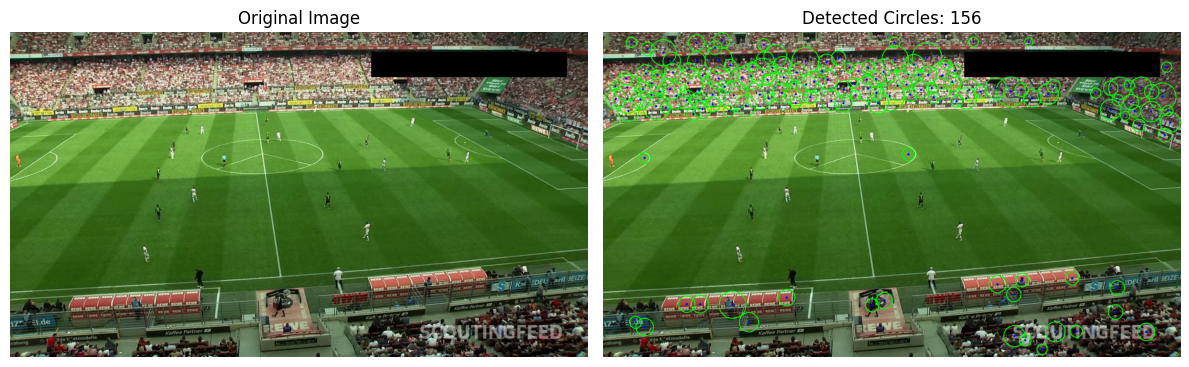

Detected circles: 156

Sample 2: 2e57b9_3_9_png.rf.80633685f79e3232dc44c395e16dfdd3.jpg


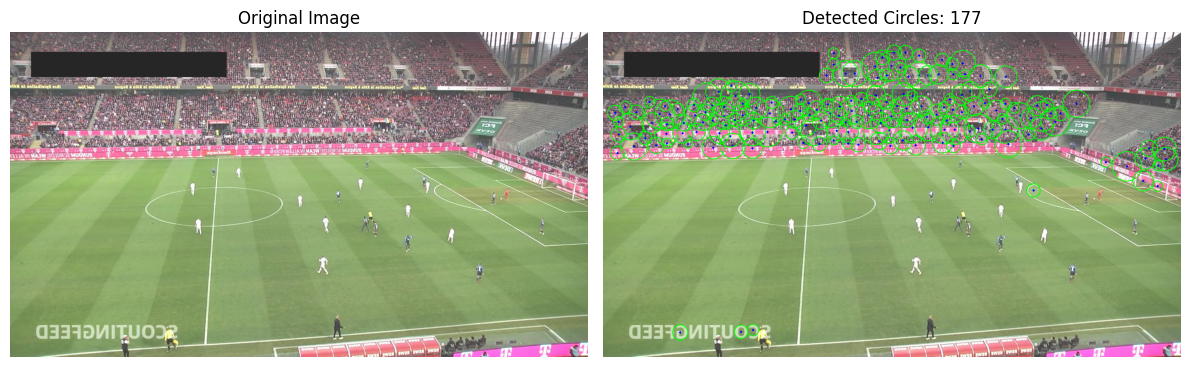

Detected circles: 177

Sample 3: cd987c_0_1_png.rf.86fa4a06126aceed101f3dc8575602ee.jpg


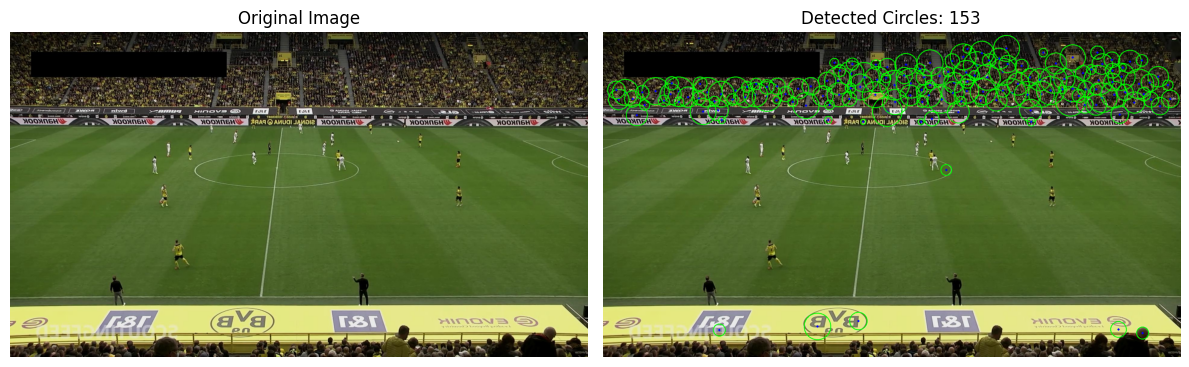

Detected circles: 153


In [10]:
def detect_ball_classical(image_path, show_result=True):
    """Classical ball detection using Circular Hough Transform"""
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)
    
    # Detect circles using HoughCircles
    circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=30,
        param1=50,
        param2=30,
        minRadius=5,
        maxRadius=50
    )
    
    result_img = img_rgb.copy()
    detected_circles = []
    
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        
        for (x, y, r) in circles:
            # Draw circle
            cv2.circle(result_img, (x, y), r, (0, 255, 0), 2)
            cv2.circle(result_img, (x, y), 2, (0, 0, 255), 3)
            detected_circles.append((x, y, r))
    
    if show_result:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img_rgb)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(result_img)
        plt.title(f'Detected Circles: {len(detected_circles)}')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return detected_circles, result_img

# Test classical detection on ball images
print("Testing Classical Ball Detection:")
for i, img_path in enumerate(random.sample(ball_images, 3)):
    print(f"\nSample {i+1}: {img_path.name}")
    circles, result = detect_ball_classical(img_path)
    print(f"Detected circles: {len(circles)}")

## Why YOLO Over Traditional Computer Vision

Initial attempts at ball identification using traditional computer vision methods (color detection, contour analysis, edge detection) proved unreliable due to over-detection of similar objects on the football field. The white ball often gets confused with:
- Field line markings
- Equipment and goal posts
- People heads on the background

This led to excessive false positives, making the system unreliable for accurate ball tracking. YOLO object detection provides more robust identification by learning from annotated training data rather than relying on simple color/shape heuristics.


## Next Steps

This notebook provides the foundation for the football tracking system. The next steps would be:

1. **Deep Learning Implementation**: Train/fine-tune a YOLO model for better ball detection
2. **Tracking Algorithm**: Implement Kalman Filter or centroid tracking
3. **Speed Calculation**: Implement a speed calculation algorithm
4. **Video Processing**: Extend to process video sequences
5. **Field Calibration**: Improve pixel-to-meter conversion using field markers
6. **iOS App Development**: Create the mobile interface

The current implementation demonstrates:
- ✅ Data visualization and exploration
- ✅ Preprocessing pipeline (Gaussian filtering, edge detection)
- ✅ Classical computer vision approach (Hough Transform)
- ✅ Focus on ball and players (ignoring referees and goalkeepers)